In [192]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
import pydot

from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from lazypredict.Supervised import LazyRegressor


import shap
shap.initjs()

In [105]:
# Load the data containing the genecounts
genecounts = pd.read_csv("full_genecounts.csv")
# Initialise the scaler
scaler = StandardScaler()
# scale the genecounts 
genecounts_scaled = scaler.fit_transform(genecounts.iloc[:, 1:])
genecounts_scaled = pd.DataFrame(genecounts_scaled, columns = genecounts.columns[1:])

genecounts_scaled.insert(0, 'gene_id', genecounts['gene_id'])
genecounts_scaled = genecounts_scaled.set_index("gene_id")
genecounts_scaled = genecounts_scaled.T
genecounts_scaled = genecounts_scaled.reset_index().rename(columns = {"index": "seq_sample_id"})
genecounts_scaled = genecounts_scaled.round(2)
genecounts_scaled

gene_id,seq_sample_id,ENSG00000000003.16,ENSG00000000419.14,ENSG00000000457.14,ENSG00000000971.17,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.15,ENSG00000001461.18,ENSG00000001497.18,...,ENSG00000308270.1,ENSG00000309097.1,ENSG00000309174.1,ENSG00000309618.1,ENSG00000310376.1,ENSG00000310517.1,ENSG00000310523.1,ENSG00000310526.1,ENSG00000310527.1,ENSG00000310533.1
0,s104,-1.22,0.09,-0.74,-0.21,-0.98,-0.41,-0.51,-0.46,0.25,...,-0.61,-1.12,-1.09,-1.25,0.45,1.69,-0.17,-0.06,-0.03,-1.34
1,s112,-0.96,0.11,-0.70,0.09,-0.77,0.02,-0.33,-0.44,0.02,...,-0.40,-1.53,-1.08,-1.24,-0.05,1.82,-0.22,0.43,0.25,-1.12
2,s13,-1.23,0.09,-0.72,-0.21,-0.86,-0.43,-0.45,-0.58,0.11,...,-0.71,-1.55,-1.48,-1.43,0.94,1.43,0.14,0.50,0.49,-1.18
3,s130,-1.29,-0.00,-0.49,-0.08,-1.13,-0.47,-0.42,-0.83,0.31,...,-1.27,-1.40,-0.69,-1.03,0.83,1.76,0.24,0.48,0.41,-1.21
4,s136,-1.06,0.13,-0.63,0.02,-0.79,-0.28,-0.46,-1.11,0.16,...,-0.80,-1.38,-1.19,-0.96,0.65,1.79,-0.26,0.02,-0.03,-1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,FP6w0R,-0.58,0.55,-0.41,0.31,-0.78,-0.11,-0.20,0.00,0.31,...,-0.06,-1.17,-0.81,-0.52,2.96,1.74,-0.99,-0.68,-0.81,-0.84
285,FP7w0L,-0.93,0.61,-0.50,0.12,-0.93,-0.20,-0.41,-0.21,0.24,...,0.43,-0.72,-1.38,-0.46,2.97,1.77,-1.16,-0.59,-0.90,-1.16
286,FP7w0R,-0.84,0.60,-0.67,0.16,-0.95,-0.24,-0.51,-0.23,0.24,...,0.29,-0.84,-1.13,-0.52,2.96,1.78,-0.76,-0.24,-0.71,-1.35
287,FP9w0R,-0.90,0.59,-0.47,-0.18,-0.81,-0.49,-0.34,-0.34,0.39,...,0.57,-0.93,-1.64,-0.26,2.92,1.86,-0.53,-0.10,-0.40,-1.32


In [106]:
# Load the full metadata
full_metadata = pd.read_csv("full_metadata.csv")
# round scaled percentage change to 2 decimal places 
full_metadata["scaled_pct_change"] = full_metadata["scaled_pct_change"].round(2)
# select onnly the variables needed for the model
metadata_full = full_metadata[["seq_sample_id", "age", "BMI", "scaled_pct_change", "category", "volume", "condition"]]
metadata_full

,seq_sample_id,age,BMI,scaled_pct_change,category,volume,condition
0,s104,46.0,29.0,0.42,Average_responder,3,RM10
1,s112,53.0,30.3,0.33,Average_responder,3,RM10
2,s13,46.0,25.3,0.92,High_responder,3,RM10
3,s130,58.0,29.9,0.26,Average_responder,3,RM10
4,s136,48.0,18.4,0.66,Average_responder,3,RM10
...,...,...,...,...,...,...,...
456,FP6w0R,21.8,20.5,0.09,No_responder,1,RM10
457,FP7w0L,21.2,28.2,0.73,Average_responder,3,RM10
458,FP7w0R,21.2,28.2,0.94,High_responder,1,RM10
459,FP9w0R,20.6,21.2,0.65,Average_responder,3,RM10


In [107]:
# join the gene expression data and the metadata
df = metadata_full.merge(genecounts_scaled, on = "seq_sample_id")
df = df.sort_values(by = "seq_sample_id")
df

,seq_sample_id,age,BMI,scaled_pct_change,category,volume,condition,ENSG00000000003.16,ENSG00000000419.14,ENSG00000000457.14,...,ENSG00000308270.1,ENSG00000309097.1,ENSG00000309174.1,ENSG00000309618.1,ENSG00000310376.1,ENSG00000310517.1,ENSG00000310523.1,ENSG00000310526.1,ENSG00000310527.1,ENSG00000310533.1
412,FP11w0L,22.3,23.6,0.04,No_responder,1,RM10,-0.91,0.52,-0.40,...,0.01,-0.74,-1.07,-0.65,3.28,2.06,-0.64,-0.18,-0.74,-1.32
411,FP11w0R,22.3,23.6,0.16,Average_responder,3,RM10,-0.80,0.46,-0.32,...,-0.07,-0.98,-0.94,-0.80,3.28,2.13,-0.66,-0.20,-0.91,-1.22
414,FP12w0L,21.3,22.8,0.20,Average_responder,1,RM10,-0.73,0.56,-0.63,...,-0.29,-0.69,-1.12,-0.55,2.84,1.71,-0.53,-0.50,-0.52,-1.14
413,FP12w0R,21.3,22.8,0.11,No_responder,3,RM10,-0.68,0.45,-0.70,...,-0.23,-0.78,-1.23,-0.26,2.78,1.68,-0.54,-0.01,-0.39,-1.61
415,FP13w0L,22.7,19.8,0.99,High_responder,3,RM10,-0.70,0.57,-0.80,...,-0.42,-0.80,-1.23,-0.55,2.87,1.72,-0.92,0.06,-0.10,-0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,s891,54.0,21.8,0.47,Average_responder,3,RM30,-1.02,0.08,-0.64,...,-0.93,-1.82,-0.89,-1.47,-0.25,1.57,0.04,0.41,0.38,-1.02
165,s903,42.0,27.3,0.82,High_responder,3,RM30,-0.95,0.07,-0.56,...,-0.61,-1.89,-1.03,-1.40,-0.25,1.52,-0.16,0.35,0.06,-1.64
81,s903,42.0,27.3,0.25,Average_responder,3,RM10,-0.95,0.07,-0.56,...,-0.61,-1.89,-1.03,-1.40,-0.25,1.52,-0.16,0.35,0.06,-1.64
82,s96,48.0,27.7,0.32,Average_responder,3,RM10,-0.89,0.30,-0.57,...,-0.84,-1.93,-1.41,-1.46,0.59,1.64,-0.06,0.25,0.35,-1.13


In [163]:
# predictor variable
X = df.drop(["seq_sample_id", "scaled_pct_change", "category", "condition"],axis = 1)
#X = np.array(X, dtype=np.float32)

# Predicted variable
y = df["scaled_pct_change"]
#y = np.array(y, dtype=np.float32)

In [164]:
#split into train and test. Test set will be 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state =123)

# from the training set, extract the validation set
X_train, X_val,  y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 123)

# print their shapes

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (294, 10929) (294,)
Validation set: (74, 10929) (74,)
Testing set: (93, 10929) (93,)


In [165]:
# Model building
model = Sequential([Input(shape = (10929,)),
    Dense(64, activation="relu"),
    Dense(64, activation= "relu"),
    Dense(1)
])

# model compilation
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss = tf.keras.losses.Huber(delta = 0.5),
             metrics= ["mean_squared_error", "mae"])

In [166]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                     │ (None, 64)                  │         699,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 703,745 (2.68 MB)

 Trainable params: 703,745 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

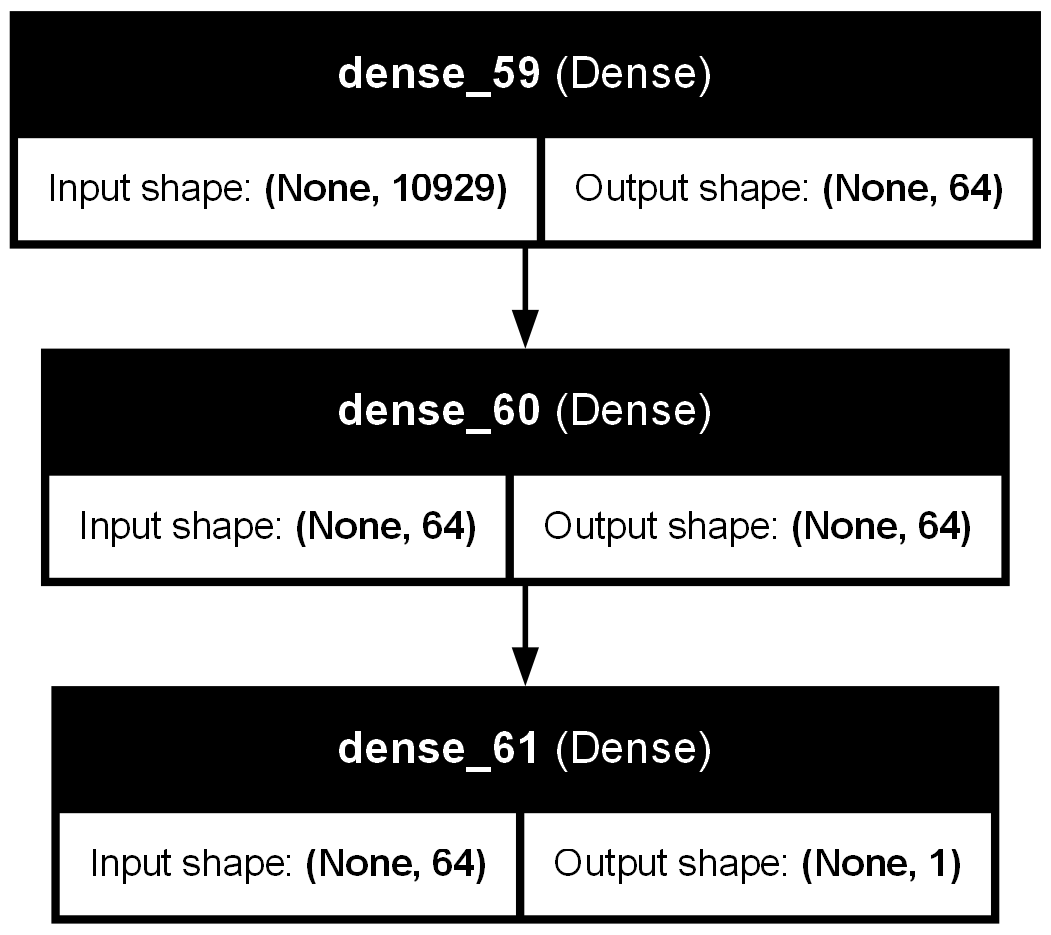

In [167]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [168]:

# Define the callback
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)
model.fit(X_train, 
         y_train,
          epochs = 32,
          batch_size=64,
         validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.2162 - mae: 0.6595 - mean_squared_error: 0.5493 - val_loss: 0.0513 - val_mae: 0.2675 - val_mean_squared_error: 0.1045
Epoch 2/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0492 - mae: 0.2590 - mean_squared_error: 0.1023 - val_loss: 0.0351 - val_mae: 0.2105 - val_mean_squared_error: 0.0707
Epoch 3/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0298 - mae: 0.1917 - mean_squared_error: 0.0604 - val_loss: 0.0272 - val_mae: 0.1963 - val_mean_squared_error: 0.0544
Epoch 4/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0301 - mae: 0.1953 - mean_squared_error: 0.0610 - val_loss: 0.0262 - val_mae: 0.1881 - val_mean_squared_error: 0.0524
Epoch 5/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0232 - mae: 0.1713 - mean_squared_error: 0.0470 - val_loss: 0.0240 - val_mae: 0.1751 - val_mean_squared_error: 0.0480
Epoch 6/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0248 - mae: 0.1751 - mean_squared_error: 0.0504 - val_lo

## Explainability using Shap


In [ ]:

# Create background dataset using local RNG
rng = np.random.default_rng(42)
indices = rng.choice(X_train.shape[0], 200, replace=False)
background = X_train.iloc[indices]

# Use SHAP GradientExplainer
explainer = shap.GradientExplainer(model, background.values)
shap_values = explainer.shap_values(X_test.iloc[0:100].values)

plt.figure(figsize=(12, 8))
# Generate summary bar plot
shap.summary_plot(shap_values, X_test.iloc[0:100].values, plot_size= (12, 8),  max_display=30, feature_names = X.columns )

#plt.gcf().set_size_inches(8, 5)
#plt.show()

# Customize font sizes
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.xlabel("SHAP value (impact on model output)", fontsize=16)
#plt.title("SHAP Summary Plot", fontsize=18)

#plt.tight_layout()
#plt.show()



In [193]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 655822
[LightGBM] [Info] Number of data points in the train set: 294, number of used features: 10929
[LightGBM] [Info] Start training from score 0.415782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,111342162034991510239313920.00,-13115380543186988867535241216.00,23699470895538.13,2.27
SGDRegressor,3733009266342864355328000.00,-439724145862582838478503936.00,4339486675023.67,1.47
TransformedTargetRegressor,1177080095032920244224.00,-138652358585562578288640.00,77056953163.42,0.62
LinearRegression,1177080095032920244224.00,-138652358585562578288640.00,77056953163.42,0.55
MLPRegressor,1.11,-11.97,0.75,7.43
KernelRidge,1.04,-3.57,0.44,0.52
GaussianProcessRegressor,1.03,-2.58,0.39,3.41
OrthogonalMatchingPursuit,1.01,-0.60,0.26,0.87
ExtraTreeRegressor,1.01,-0.48,0.25,1.28


## Dimensionality reduction using autoencoder

In [49]:
input_layer = Input(shape= (10929,))
encoded = Dense(512, activation= "relu")(input_layer)
encoded = Dense(1280, activation = "relu")(encoded) # 128 is the size we want the compressed data's dimension

decoded = Dense(512, activation="relu")(encoded)
decoded = Dense(10929, activation= "sigmoid")(decoded)


# Autoencoder model

autoencoder = Model(inputs=input_layer, outputs=decoded)


In [50]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss = tf.keras.losses.Huber(delta = 0.5),
             metrics= ["mean_squared_error", "mae"])

In [51]:
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 10929)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 512)                 │       5,596,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1280)                │         656,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 10929)               │       5,606,577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,515,249 (47.74 MB)

 Trainable params: 12,515,249 (47.74 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
autoencoder.fit(X_train, 
         X_train,
          epochs = 30,
          batch_size=64,
         validation_split= 0.2)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.3501 - mae: 0.9244 - mean_squared_error: 1.5566 - val_loss: 0.3400 - val_mae: 0.9026 - val_mean_squared_error: 1.5465
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3341 - mae: 0.8898 - mean_squared_error: 1.4884 - val_loss: 0.3045 - val_mae: 0.8252 - val_mean_squared_error: 1.3951
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2938 - mae: 0.8021 - mean_squared_error: 1.3241 - val_loss: 0.2541 - val_mae: 0.7158 - val_mean_squared_error: 1.1832
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2446 - mae: 0.6950 - mean_squared_error: 1.1073 - val_loss: 0.2166 - val_mae: 0.6344 - val_mean_squared_error: 1.0260
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2112 - mae: 0.6225 - mean_squared_error: 0.9758 - val_loss: 0.1995 - val_mae: 0.5970 - val_mean_squared_error: 0.9552
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1975 - mae: 0.5923 - mean_squared_error: 0.9090 - val_l

In [53]:
encoder = Model(inputs=input_layer, outputs=encoded)
compressed_features = encoder.predict(X)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


## Principal component analyses to reduce data dimension

In [91]:
# predictor variable
#Q = df.drop(["seq_sample_id", "scaled_pct_change", "category", "condition"],axis = 1)


# Predicted variable
#R = df["scaled_pct_change"]


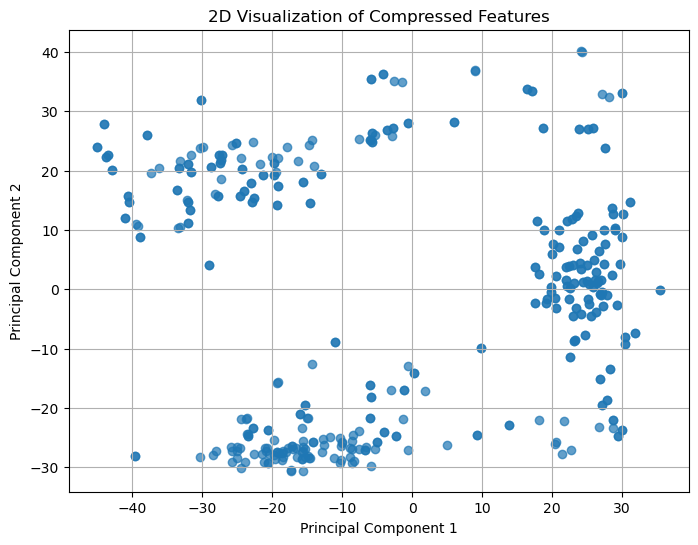

In [92]:
pca = PCA(n_components=0.95) # keep 95% of variance
reduced = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
plt.title("2D Visualization of Compressed Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [93]:
pca_reduced = pd.DataFrame(reduced, columns =[f'PC{i+1}' for i in range(reduced.shape[1])])
pca_reduced["scaled_pct_change"] = y
pca_reduced

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,scaled_pct_change
0,-17.009553,-26.955513,-1.102163,0.368799,-5.497852,1.831922,-6.048456,4.257982,1.382672,2.627725,...,-0.190661,-0.920189,0.844159,-0.546784,-0.497475,0.362383,-0.337828,-0.388939,-0.098863,0.42
1,-15.353356,-26.942293,0.185012,-1.158036,-4.245115,5.660300,-4.050218,5.070303,1.787406,0.628710,...,0.046216,-1.052141,1.869912,-1.238542,-0.317609,0.148157,-0.026470,-0.262625,0.293308,0.33
2,-21.552706,-27.713138,4.058438,-3.256170,0.096390,-4.785376,-1.601513,-5.461312,-2.751303,-1.445772,...,0.436271,0.002461,0.844046,-0.809758,0.190378,1.020939,-0.063765,0.592022,0.071233,0.92
3,-15.819796,-27.496480,5.795441,-3.796850,-1.493833,-4.803340,-1.009635,-6.533948,-0.396712,0.839036,...,0.184521,0.223610,1.054939,-0.595867,0.233978,0.819716,-0.183320,0.805415,0.220296,0.26
4,-10.288205,-29.356797,11.681490,-4.323152,8.130007,6.065460,-8.691654,-1.140684,-5.287556,1.994333,...,-0.572495,-0.538535,-1.767588,-0.818825,-0.071451,-1.383901,0.591652,1.133275,0.542815,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,24.335984,8.066202,3.777806,-7.158326,-1.440083,-3.531420,-2.353882,-4.026289,-1.480920,-2.432147,...,-1.671153,0.104609,0.728539,-0.960421,0.386182,0.241347,0.058755,0.369574,-1.089264,0.09
457,24.098635,-4.157770,-0.301224,-0.024118,-0.124915,-4.992784,1.344683,-0.830112,-4.298889,-2.820484,...,0.862879,-0.186988,-0.504917,-1.607047,-0.697918,-0.032893,-0.480830,0.892437,-0.232744,0.73
458,24.098635,-4.157770,-0.301224,-0.024118,-0.124915,-4.992784,1.344683,-0.830112,-4.298889,-2.820484,...,0.862879,-0.186988,-0.504917,-1.607047,-0.697918,-0.032893,-0.480830,0.892437,-0.232744,0.94
459,24.384951,1.208084,0.651528,-0.434656,3.421796,-1.957035,-2.008732,6.459387,-1.330097,3.367509,...,-0.298588,-1.998757,0.479009,-0.639858,0.626854,-1.150981,-0.531257,0.782230,-0.983327,0.65


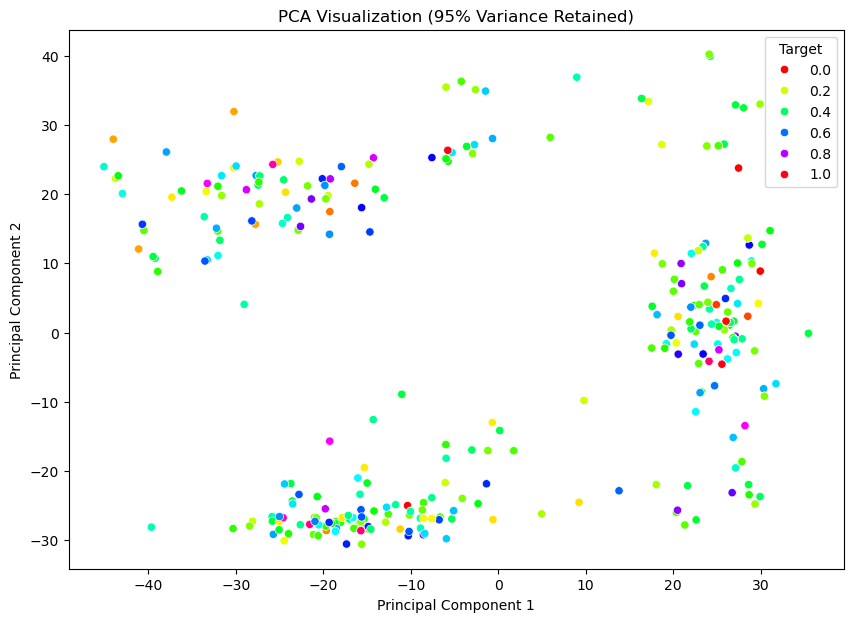

In [94]:

# Step 6: Visualize the first two principal components
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='scaled_pct_change', palette='hsv', data=pca_reduced)
plt.title('PCA Visualization (95% Variance Retained)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Target')
plt.show()


In [96]:

# Get the loadings (contributions of original features to each PC)
loadings = pd.DataFrame(pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=Q.columns
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122
age,-0.050129,0.964717,0.120903,0.015171,0.062403,0.000751,-0.029188,0.058774,-0.012726,0.050265,...,-0.007458,0.004140,0.001257,-0.010423,0.002947,-0.008660,-0.002540,-0.004820,-0.000182,0.000722
BMI,0.067902,0.013690,-0.031331,0.830945,0.119326,0.074277,0.299830,0.091041,0.013335,0.067471,...,0.012940,-0.007855,0.004931,0.011902,-0.014087,0.012877,0.009774,0.002112,-0.007776,0.011266
volume,0.002982,0.010600,0.015792,0.030208,0.009767,-0.009030,0.011955,-0.020202,-0.005784,-0.042595,...,-0.063165,-0.030768,0.004365,0.047943,-0.008079,-0.061718,0.029248,0.058458,0.000612,-0.033068
ENSG00000000003.16,-0.004263,-0.002014,-0.004791,-0.005714,0.007216,0.001622,0.006149,0.003698,-0.003895,-0.002396,...,0.001114,0.006296,-0.022292,-0.019975,0.012014,-0.008929,0.001477,-0.005940,0.007916,-0.005268
ENSG00000000419.14,-0.008139,-0.001859,0.007411,0.001244,0.011935,0.000540,-0.002468,-0.003021,-0.001546,0.008679,...,0.003066,-0.004933,0.004561,0.013359,-0.004579,0.004480,0.006246,-0.004218,0.002130,-0.003171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000310517.1,-0.004488,-0.000449,-0.011975,-0.003728,0.002270,0.010460,-0.005179,0.002669,0.016462,0.009753,...,-0.002367,-0.003214,0.004165,-0.002016,-0.005818,0.000870,0.003296,0.000481,-0.002417,0.004812
ENSG00000310523.1,0.014969,0.003623,0.003483,-0.003826,-0.008769,0.001259,-0.003984,-0.005837,-0.004801,-0.008876,...,0.000736,0.002484,-0.003476,-0.004323,-0.004170,-0.004508,0.004151,0.003358,0.005149,0.003233
ENSG00000310526.1,0.016359,0.000814,0.005875,0.000460,-0.002477,0.001826,-0.003081,-0.011095,-0.000971,0.001992,...,-0.009196,0.005038,-0.007326,-0.007839,-0.026170,0.016313,0.006486,-0.010249,-0.009897,0.003351
ENSG00000310527.1,0.018280,0.001090,0.009078,0.001407,-0.001048,0.002350,-0.003119,-0.009906,-0.003413,-0.000848,...,-0.005824,-0.000999,-0.038967,-0.018169,-0.025603,0.019576,-0.026131,0.000422,0.001560,0.003958


Reduce to 2D using t-SNE

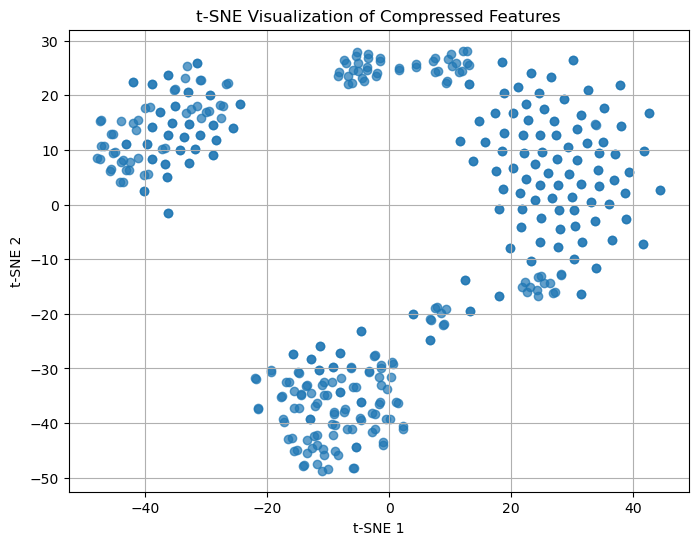

In [64]:
tsne = TSNE(n_components=2, perplexity=30, random_state=123)
reduced_tsne = tsne.fit_transform(reduced)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], alpha=0.7)
plt.title("t-SNE Visualization of Compressed Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

In [67]:
tsne_from_reduced = pd.DataFrame(reduced_tsne, columns = ["TSNE1", "TSNE2"])
tsne_from_reduced["target"] = y
tsne_from_reduced

,TSNE1,TSNE2,target
0,-9.114462,-38.326721,0.04
1,-9.005971,-37.964729,0.16
2,-5.963078,-48.301907,0.20
3,-5.695563,-48.221401,0.11
4,-8.331006,-45.788815,0.99
...,...,...,...
456,20.268131,16.743498,0.47
457,26.712139,1.223836,0.82
458,26.712137,1.223836,0.25
459,27.541100,8.270517,0.32
